https://doi.pangaea.de/10.1594/PANGAEA.923197

# Thermoacoustic predictions

Further work can be achieved here.

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow.keras as keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import find_peaks 

print(tf.__version__)
print(tf.keras.__version__)


from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

LSTM = keras.models.load_model('Neural Networks/lstm_model_thesis')
CNN = keras.models.load_model('Neural Networks/cnn_model_thesis')


2.10.0
2.10.0


In [2]:
def var_data(dataset, window_size):
    """
    Calculates moving variance on solution
    
    dataset := numpy array, expects form of (no. of solns, length of soln.)
    window_size := int, size of moving window
    """
    
    ## Get shapes of dataset
    n = dataset.shape[0]
    m = dataset.shape[1]

    ## Calculates the amount of steps needed to transfer over
    ##  the solution
    window_steps = m - window_size

    ## Initiates array to hold data
    var_dat = np.zeros((n,window_steps))

    ## Begins moving window
    for j in range(n):
        for i in range(window_steps):
            ## Calculates variance within window
            var_dat[j,i] = dataset[j,i:window_size+i].var()
    
    ## Returns moving variance for user
    return var_dat

def auto_data(dataset, window_size, k=1):
    """
    Calculates autocorrelation of solution
    
    dataset := numpy array, expects form of (no. of solns, length of soln.)
    window_size := int, size of moving windows
    k := int, time step lag between windows (k=1 == lag-1 AC)
    """
    
    ## Get shapes of dataset
    n = dataset.shape[0]
    m = dataset.shape[1]
    
    ## Calculates the amount of steps needed to transfer over
    ##  the solution
    window_steps = m - (window_size + k)

    ## Initiates AC array
    auto_dat = np.zeros((n,window_steps))

    ## Begins moving window
    for j in range(n):
        ## Grabs initial window
        a = dataset[j, 0 :  window_size]
        for i in range(window_steps):
            ## Grabs next window
            b = dataset[j, i + k : i + k + window_size]
            
            ## Calculates the correlation of the windows
            auto_dat[j,i] = np.corrcoef(a,b)[0,1]
            
            ## old window becomes new window
            a = b
    
    # Returns AC to user
    return auto_dat

def trim_data(var, auto, labels, tol, tol1):
    """
    Trims B-tipping data for user. Uses peak in variance as 
        indication that we have passed a tipping point.
    
    var := numpy array, an array containing all the variance data for some solution
    auto := numpy array, ''''' AC data ''' 
    labels := numpy array, ''' the labels for some solution
    tol := int, the amount of values required before max variance has occurred
    tol1 := int, how close to peak in variance we need
    """
    
    ## Initiates 3 temporary lists
    temp1 = []
    temp2 = []
    temp3 = []

    ## Begins loop to trim datasets
    for i in range(len(var)):
        
        ## Finds peak in variance
        end = np.argmax(var[i])
        
        ## Finds starting position for data trimming
        start = end-tol

        ## If peak has 'tol' values before it
        if start > 0:
            
            ## Appends the new trimmed sets to their repsective list
            temp1.append(var[i,start:end-tol1])
            temp2.append(auto[i,start:end-tol1])
            temp3.append(labels[i])
            
    ## Returns trimmed data to user
    return np.array(temp1), np.array(temp2), np.array(temp3) 

def trim_r_data(var, auto, labels, tol, tol1):
    """
    Trims R-tipping data for user. Uses peak in variance as 
        indication that we have passed a tipping point.
    
    var := numpy array, an array containing all the variance data for some solution
    auto := numpy array, ''''' AC data ''' 
    labels := numpy array, ''' the labels for some solution
    tol := int, the amount of values required before max variance has occurred
    tol1 := int, how close to peak in variance we need
    """
    
    temp1 = []
    temp2 = []
    temp3 = []

    for i in range(len(var)):
        ## If solution tips...
        if labels[i] == 1:
            ## Finds peak in variance
            end = np.argmax(var[i])

            ## Finds starting position for data trimming
            start = end-tol

            ## If peak has 'tol' values before it
            if start > 0:

                ## Appends the new trimmed sets to their repsective list
                temp1.append(var[i,start:end-tol1])
                temp2.append(auto[i,start:end-tol1])
                temp3.append(labels[i])

        ## Else, solution never tipped, peak in variance poor indicator
        ##  for data collection
        else:
            ## Take final values instead
            end = -1
            start = end-tol
            
            temp1.append(var[i,start:end-tol1])
            temp2.append(auto[i,start:end-tol1])
            temp3.append(labels[i])

    ## Returns trimmed dataset for the user
    return np.array(temp1), np.array(temp2), np.array(temp3)

def z_score_norm(data):
    """
    Min-Max normalisation method
    
    data := numpy array, contains a collection of sequences of data
    """
    
    ## Initiates array for user
    z_score_data = np.zeros(data.shape)
    
    ## Calculates Z-score norm for user
    for i in range(data.shape[0]):
        mean_data = data[i].mean()
        std_data = data[i].std()
        z_score_data[i] = (data[i] - mean_data) / std_data
    
    ## Returns normalised data
    return z_score_data


def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [3]:
def create_time_series(data, steps_back=5, steps_forward=1, features = 2):
    """Creates time series from set of data.
        Takes in sample of data, creates time series of final (step_forward + step_back) steps.
        
        data := array, has form (# samples, # features, # time steps)
        steps_back, steps_forward := int, amount of steps_back used to guess steps_forward
        features := amount of features present in the data (ex. variance and autocorrelation)
        
        Returns 2 arrays, where 'X' consists of (t-step_back, ..., t-1)
                                'y' consists of (t)
        """
    
    ## Initialise arrays for data
    ##  Has shape (sample, timesteps, features)
    X = np.zeros((data.shape[0],steps_back,features))
    y = np.zeros((data.shape[0],steps_forward,features))
    
    ## Begin loop for each sample
    for i in range(data.shape[0]):
        ## ... and each feature
        for j in range(features):
            X[i,:,j] = data[i,j,-(steps_back+steps_forward):-steps_forward]
            y[i,:,j] = data[i,j,-steps_forward:]
    
    return X,y

In [4]:
def show_pred(inp, actual, save_as=None):
    
    if len(inp.shape) != 3:
        inp = inp.reshape(1,inp.shape[0],inp.shape[1])
    
    if len(actual.shape) != 3:
        actual = actual.reshape(1,actual.shape[0],actual.shape[1])
    
    plt.figure(figsize=(10,5))
    res = LSTM.predict(inp, verbose=0)
    n = inp.shape[1]
    
    
    plt.subplot(1,2,1)
    plt.plot(inp[0,:,0], label='Input data')
    plt.plot(n, res[0,0,0], 'ro', label='Predicted Value')
    plt.plot(n, actual[0,0,0], 'gs', label='True Value')
    plt.plot(0,0, 'k.', alpha=0, label = 'Probability of tipping = ' + str(predict_bifur(inp)))
    
    for i in range(1, res.shape[1]):
        plt.plot([n+i, n+i], [res[0,i,0], actual[0,i,0]], '0.8')
        plt.plot(n+i, res[0,i,0], 'ro')
        plt.plot(n+i, actual[0,i,0], 'gs')
    
    plt.xlabel('Time', fontsize=17)
    plt.ylabel('Variance', fontsize=17)

    
    #plt.ylim(0,1)
    plt.legend()
    
    
    
    plt.subplot(1,2,2)
    plt.plot(inp[0,:,1], label='Input data')
    
    plt.plot(n, res[0,0,1], 'ro')
    plt.plot(n, actual[0,0,1], 'gs')
    
    for i in range(1, res.shape[1]):
        plt.plot([n+i, n+i], [res[0,i,1], actual[0,i,1]], '0.8')
        plt.plot(n+i, res[0,i,1], 'ro')
        plt.plot(n+i, actual[0,i,1], 'gs')
    
    plt.xlabel('Time', fontsize=17)
    plt.ylabel('AC', fontsize=17)
    
    
    plt.ylim(-1.1,1.1)
    
    if save_as != None:
        plt.savefig(save_as, dpi=300)
    
    plt.show()

In [5]:
def predict_bifur(time_series):
    
    if len(time_series.shape) != 3:
        time_series = time_series.reshape(1,time_series.shape[0],time_series.shape[1])
    LSTM_pred = LSTM.predict(time_series, verbose=0)
    CNN_pred = CNN.predict(LSTM_pred, verbose=0)
    
    return CNN_pred[0,0]

In [6]:
df = pd.read_csv('Datasets/Hennekam-etal_2020/datasets/64PE406-E1_calibratedXRF.tab', sep='\t',skiprows=18)

df.head()

,Age [ka BP],Depth [m],Al [mg/kg],Ba [mg/kg],Mo [mg/kg],Ti [mg/kg],U [mg/kg]
0,10.060,0.011,62571.901,808.441,10.112,4364.288,7.590
1,10.097,0.012,61456.711,787.014,8.261,4185.859,8.060
2,10.134,0.013,58475.228,697.289,11.415,4338.507,4.333
3,10.170,0.014,57720.503,611.615,11.234,4161.578,7.184
4,10.207,0.015,57393.947,510.784,6.970,4305.302,8.979


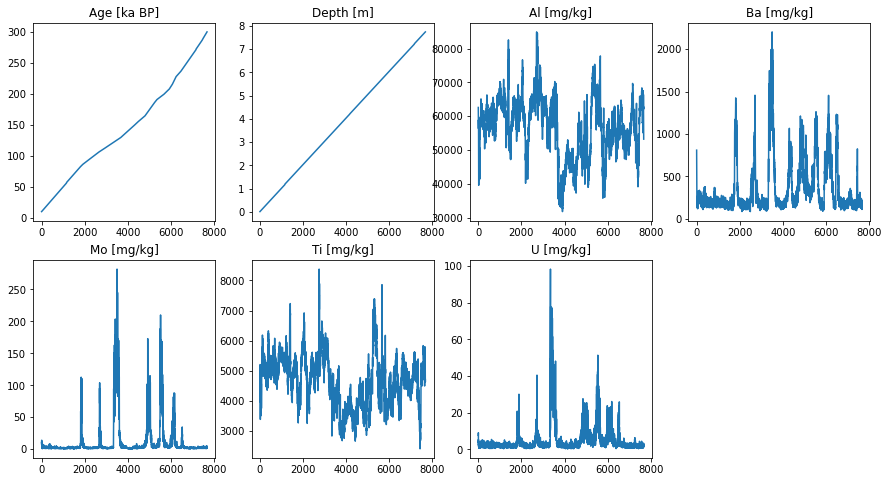

In [7]:
plt.figure(figsize=(15,8))

for i in range(len(df.keys())):
    plt.subplot(2,4,i+1)
    arr = np.asarray(df[df.keys()[i]])
    plt.title(df.keys()[i])

    plt.plot(arr)

___

## 64PE406-E1_calibratedXRF.tab

In [8]:
df = pd.read_csv('Datasets/Hennekam-etal_2020/datasets/64PE406-E1_calibratedXRF.tab', sep='\t',skiprows=18)
df.pop('Age [ka BP]')
df.pop('Depth [m]')
df.head()

,Al [mg/kg],Ba [mg/kg],Mo [mg/kg],Ti [mg/kg],U [mg/kg]
0,62571.901,808.441,10.112,4364.288,7.590
1,61456.711,787.014,8.261,4185.859,8.060
2,58475.228,697.289,11.415,4338.507,4.333
3,57720.503,611.615,11.234,4161.578,7.184
4,57393.947,510.784,6.970,4305.302,8.979


In [9]:
## Min-Max Normalisation
df=(df-df.min())/(df.max()-df.min())

df.head()

,Al [mg/kg],Ba [mg/kg],Mo [mg/kg],Ti [mg/kg],U [mg/kg]
0,0.579584,0.341934,0.034150,0.326982,0.075041
1,0.558616,0.331825,0.027566,0.297027,0.079836
2,0.502557,0.289495,0.038784,0.322654,0.041811
3,0.488366,0.249077,0.038140,0.292950,0.070899
4,0.482226,0.201507,0.022974,0.317079,0.089213


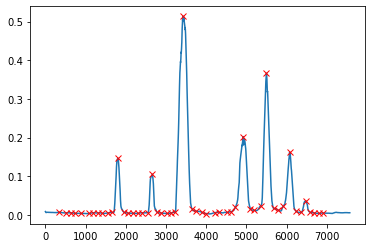

In [10]:
a = np.asarray(df['Mo [mg/kg]'])
a = moving_average(a, 100)

peaks, _ = find_peaks(a, distance=100)

peaks = peaks[peaks>300]
peaks = peaks[peaks<7000]
plt.plot(a)
plt.plot(peaks, a[peaks], 'rx')

## Single Peaks

In [11]:
peaks, peaks.shape

(array([ 343,  524,  639,  742,  886, 1086, 1190, 1317, 1420, 1548, 1651,
        1808, 1946, 2054, 2188, 2299, 2401, 2552, 2660, 2781, 2884, 3016,
        3126, 3230, 3427, 3647, 3755, 3884, 3997, 4210, 4314, 4511, 4612,
        4726, 4921, 5101, 5201, 5366, 5499, 5676, 5781, 5918, 6077, 6239,
        6370, 6473, 6574, 6691, 6794, 6915], dtype=int64),
 (50,))

In [12]:
before = 300
after = 25
size = before+after

dataset = np.zeros((peaks.shape[0],size))

for i in range(peaks.shape[0]):
    dataset[i] = a[peaks[i]-before: peaks[i]+after]

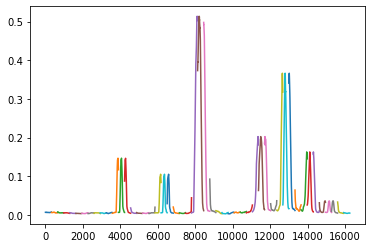

In [13]:
dif = before+after
t = np.linspace(0,peaks.shape[0]*size-1,peaks.shape[0]*size)
for i in range(dataset.shape[0]):
    plt.plot(t[i*dif:(i+1)*dif], dataset[i])

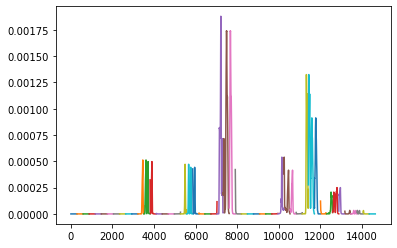

In [14]:
n = int(dataset.shape[1] * 0.1)

var_dat = var_data(dataset, n)
auto_dat = auto_data(dataset, n-1)

dif = var_dat.shape[1]
for i in range(dataset.shape[0]):
    plt.plot(t[i*dif:(i+1)*dif], var_dat[i])

In [15]:
tol = 135
tol1 = 35

temp1 = []
temp2 = []

for i in range(len(var_dat)):
    end = np.argmax(var_dat[i])
    start = end-tol
    
    if start > 0:
        temp1.append(var_dat[i,start:end-tol1])
        temp2.append(auto_dat[i,start:end-tol1])
        
trimmed_var = np.array(temp1)
trimmed_auto = np.array(temp2)

trimmed_var.shape

(21, 100)

In [16]:
normalised_var = z_score_norm(trimmed_var)

In [17]:
data = np.zeros((normalised_var.shape[0], 2, normalised_var.shape[1]))

for i in range(trimmed_var.shape[0]):
    data[i,0] = normalised_var[i]
    data[i,1] = trimmed_auto[i]

data.shape, normalised_var[0,:10], trimmed_auto[0,:10], data[0,0,0:10], data[0,1,0:10]

((21, 2, 100),
 array([-1.03245135, -1.04543296, -1.04614379, -1.04344342, -1.03150321,
        -1.02036104, -1.02463644, -1.03216833, -1.03649357, -1.03682139]),
 array([0.72741744, 0.74832031, 0.75061911, 0.75350002, 0.78516745,
        0.79611865, 0.78828985, 0.77536297, 0.76780725, 0.78005959]),
 array([-1.03245135, -1.04543296, -1.04614379, -1.04344342, -1.03150321,
        -1.02036104, -1.02463644, -1.03216833, -1.03649357, -1.03682139]),
 array([0.72741744, 0.74832031, 0.75061911, 0.75350002, 0.78516745,
        0.79611865, 0.78828985, 0.77536297, 0.76780725, 0.78005959]))

In [18]:
steps_back = 85
steps_forward = 15
features = data.shape[1]

X, y = create_time_series(data, steps_back, steps_forward, features)

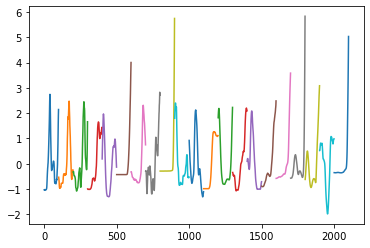

In [19]:
dif = tol - tol1
for i in range(trimmed_var.shape[0]):
    plt.plot(t[i*dif:(i+1)*dif], normalised_var[i])

In [20]:
@interact(k=(0,len(y)-1,1))
def g(k):
    show_pred(X[k], y[k])

interactive(children=(IntSlider(value=10, description='k', max=20), Output()), _dom_classes=('widget-interact'…

In [21]:
LSTM.evaluate(X, y, verbose=1)

1/1 [==============================] - 1s 646ms/step - loss: 0.4432


0.4432029724121094

_____

## Continuous Data

In [22]:
a_alt = a.reshape((1,a.shape[0]))

window_size = 1000

full_var = var_data(a_alt, window_size)
full_auto = auto_data(a_alt, window_size-1)

var_continuous = np.zeros((full_var.shape[1]-100, 100))
auto_continuous = np.zeros((full_var.shape[1]-100, 100))

for i in range(full_var.shape[1]-100):
    var_continuous[i] = full_var[0,i:i+100]
    auto_continuous[i] = full_auto[0,i:i+100]
    
normalised_var_cont = z_score_norm(var_continuous)

data = np.zeros((normalised_var_cont.shape[0], 2, normalised_var_cont.shape[1]))

for i in range(normalised_var_cont.shape[0]):
    data[i,0] = normalised_var_cont[i]
    data[i,1] = auto_continuous[i]

data.shape, normalised_var_cont[0,:10], trimmed_auto[0,:10], data[0,0,0:10], data[0,1,0:10]


((6473, 2, 100),
 array([-1.5171657 , -1.8046385 , -2.02593057, -2.19738872, -2.30052749,
        -2.34794896, -2.36220791, -2.31208945, -2.24361829, -2.16369485]),
 array([0.72741744, 0.74832031, 0.75061911, 0.75350002, 0.78516745,
        0.79611865, 0.78828985, 0.77536297, 0.76780725, 0.78005959]),
 array([-1.5171657 , -1.8046385 , -2.02593057, -2.19738872, -2.30052749,
        -2.34794896, -2.36220791, -2.31208945, -2.24361829, -2.16369485]),
 array([0.9991277 , 0.99914913, 0.9991611 , 0.99919511, 0.99923079,
        0.99924501, 0.99932275, 0.99933472, 0.99934065, 0.99936647]))

In [23]:
steps_back = 85
steps_forward = 15
features = data.shape[1]

X, y = create_time_series(data, steps_back, steps_forward, features)

In [24]:
preds = np.zeros((X.shape[0]))

for i in range(X.shape[0]):
    preds[i] = predict_bifur(X[i])

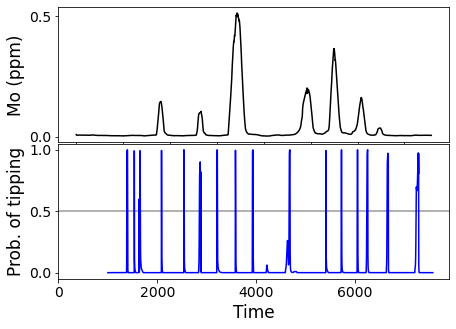

In [25]:
t = np.linspace(window_size, a.shape[0], preds.shape[0])


plt.figure(figsize=(7,5))
plt.subplot(2,1,1)
plt.plot(a, 'k')
plt.ylabel('Mo (ppm)', fontsize=17)
plt.yticks(np.arange(0,1,0.5), fontsize=14)

plt.subplot(2,1,2)
plt.axhline(0.5, color='k', alpha=0.4)
plt.plot(t,preds, color='b')
plt.xlabel('Time', fontsize=17)
plt.ylabel('Prob. of tipping', fontsize=17)
plt.yticks(np.arange(0,1.5,0.5), fontsize=14)
plt.xticks(np.arange(0,a.shape[0],2000), fontsize=14)

plt.subplots_adjust(hspace=0.01)


# plt.savefig('mo_real_time.pdf', dpi=300)

plt.show()